# Negative L1 norm prior experiment

This code attempts to learn the 8D prior
$J(x) = -||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i) = -t/2 - |x|$

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/NegL1_prior_8D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Negative L1 Norm J(x) = -||x||_1
    # S(x, t) = -t/2 - |x| (per dimension)
    # For n dimensions: S(x, t) = - (n*t)/2 - ||x||_1
    
    dim = y.shape[1]
    l1_norm = np.sum(np.abs(y), axis=1)
    return -(t) / 2.0 - l1_norm


def prior_true(y):
    # J(x) = -||x||_1
    return -np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Convex functions(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Convex functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}")
        plt.xlabel('$x_1$')
        plt.ylabel('Prior functions ($0,x_2$,0)')
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 8

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 30000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 1836.416259765625
iteration 0 loss 34.87498474121094


iteration 5000 loss 0.05333907902240753


iteration 10000 loss 0.04120869189500809


iteration 15000 loss 0.03542220965027809


iteration 20000 loss 0.04222336411476135


iteration 25000 loss 0.026643477380275726


iteration 30000 loss 0.02334699034690857


iteration 35000 loss 0.0208307895809412


iteration 40000 loss 0.01863221824169159


iteration 45000 loss 0.016782984137535095


iteration 50000 loss 0.015311121009290218


iteration 55000 loss 0.013758242130279541


iteration 60000 loss 0.01394217275083065


iteration 65000 loss 0.011816876009106636


iteration 70000 loss 0.010713799856603146


iteration 75000 loss 0.035836052149534225


iteration 80000 loss 0.0097963847219944


iteration 85000 loss 0.030498167499899864


iteration 90000 loss 0.26628538966178894


iteration 95000 loss 0.007955861277878284


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.00707896426320076


iteration 105000 loss 0.006882909219712019


iteration 110000 loss 0.006336465012282133


iteration 115000 loss 0.006046626716852188


iteration 120000 loss 0.005743721500039101


iteration 125000 loss 0.005505239125341177


iteration 130000 loss 0.005294523201882839


iteration 135000 loss 0.005099573638290167


iteration 140000 loss 0.007829158566892147


iteration 145000 loss 0.00476085813716054


iteration 150000 loss 0.004611145239323378


iteration 155000 loss 0.004483988042920828


iteration 160000 loss 0.004352159798145294


iteration 165000 loss 0.004233669489622116


iteration 170000 loss 0.004122464917600155


iteration 175000 loss 0.0040177651681005955


iteration 180000 loss 0.003921401686966419


iteration 185000 loss 0.0038323772605508566


iteration 190000 loss 0.0037457284051924944


iteration 195000 loss 0.0036651641130447388


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.00358952977694571


iteration 205000 loss 0.003552463836967945


iteration 210000 loss 0.0034878202714025974


iteration 215000 loss 0.0034281648695468903


iteration 220000 loss 0.0033689714036881924


iteration 225000 loss 0.00331262219697237


iteration 230000 loss 0.0032594690565019846


iteration 235000 loss 0.0032094318885356188


iteration 240000 loss 0.0031597206834703684


iteration 245000 loss 0.003111892146989703


iteration 250000 loss 0.0030684377998113632


iteration 255000 loss 0.0030264800880104303


iteration 260000 loss 0.002987137995660305


iteration 265000 loss 0.002947709523141384


iteration 270000 loss 0.0029100782703608274


iteration 275000 loss 0.002875604433938861


iteration 280000 loss 0.002840631175786257


iteration 285000 loss 0.0028074209112674


iteration 290000 loss 0.0027763305697590113


iteration 295000 loss 0.0027464167214930058


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.0027161838952451944


iteration 305000 loss 0.0027086797636002302


iteration 310000 loss 0.002681533806025982


iteration 315000 loss 0.00265523255802691


iteration 320000 loss 0.002629471942782402


iteration 325000 loss 0.0026044307742267847


iteration 330000 loss 0.0025800513103604317


iteration 335000 loss 0.0025562464725226164


iteration 340000 loss 0.002532263519242406


iteration 345000 loss 0.0025094205047935247


iteration 350000 loss 0.0024871104396879673


iteration 355000 loss 0.002465273020789027


iteration 360000 loss 0.0024440328124910593


iteration 365000 loss 0.002422340912744403


iteration 370000 loss 0.002402347745373845


iteration 375000 loss 0.002382494043558836


iteration 380000 loss 0.002362085971981287


iteration 385000 loss 0.0023432651069015265


iteration 390000 loss 0.0023249394726008177


iteration 395000 loss 0.0023062610998749733


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.002288190182298422


iteration 405000 loss 0.0022829086519777775


iteration 410000 loss 0.002274857135489583


iteration 415000 loss 0.002267114818096161


iteration 420000 loss 0.002259437693282962


iteration 425000 loss 0.0022518294863402843


iteration 430000 loss 0.0022443553898483515


iteration 435000 loss 0.002236927393823862


iteration 440000 loss 0.002229610225185752


iteration 445000 loss 0.0022223643027246


iteration 450000 loss 0.00221517076715827


iteration 455000 loss 0.0022080563940107822


iteration 460000 loss 0.0022009946405887604


iteration 465000 loss 0.0021940444130450487


iteration 470000 loss 0.0021871093194931746


iteration 475000 loss 0.0021803430281579494


iteration 480000 loss 0.002173567656427622


iteration 485000 loss 0.0021668102126568556


iteration 490000 loss 0.0021601018961519003


iteration 495000 loss 0.0021533730905503035


L2 loss -- Plot

loss 523.8587646484375


loss 463.73223876953125


loss 435.52984619140625


loss 417.4893493652344


loss 405.533447265625


loss 397.99676513671875


loss 393.7557373046875


loss 391.6963195800781


loss 390.8424072265625


loss 390.5452575683594


loss 390.4623718261719


loss 390.4452209472656


loss 390.44287109375


loss 390.4426574707031


loss 390.442626953125


loss 390.44268798828125


loss 390.442626953125


loss 390.4426574707031


loss 390.442626953125


loss 390.442626953125


loss 390.4426574707031


loss 390.442626953125


loss 390.4426574707031


loss 390.442626953125


loss 390.4426574707031


loss 390.4426574707031


loss 390.4426574707031


loss 390.442626953125


loss 390.4426574707031


loss 390.4426574707031


loss 390.442626953125


loss 390.442626953125


loss 390.4426574707031


loss 390.4426574707031


loss 390.4426574707031


loss 390.4426574707031


loss 390.4426574707031


loss 390.442626953125


loss 390.442626953125


loss 390.4426574707031


final mse:  1.037079400134644e-08
max, min: 2.9668176 -3.0253909
loss 523.8587646484375


loss 465.6217956542969


loss 438.727783203125


loss 421.2781982421875


loss 409.88916015625


loss 402.9324951171875


loss 399.115966796875


loss 397.2868347167969


loss 396.53021240234375


loss 396.26385498046875


loss 396.1868896484375


loss 396.1697998046875


loss 396.16717529296875


loss 396.16693115234375


loss 396.1669006347656


loss 396.1669006347656


loss 396.16693115234375


loss 396.16693115234375


loss 396.1669006347656


loss 396.1668701171875


loss 396.1669006347656


loss 396.1669006347656


loss 396.1669006347656


loss 396.1669006347656


loss 396.1669006347656


loss 396.1669006347656


loss 396.1669006347656


loss 396.1669006347656


loss 396.1669006347656


loss 396.1668701171875


loss 396.1668701171875


loss 396.1668701171875


loss 396.1669006347656


loss 396.1669006347656


loss 396.1668701171875


loss 396.1668701171875


loss 396.1669006347656


loss 396.16693115234375


loss 396.1669006347656


loss 396.1669006347656


final mse:  1.0409498152341712e-08
max, min: 2.9614518 -2.9895465


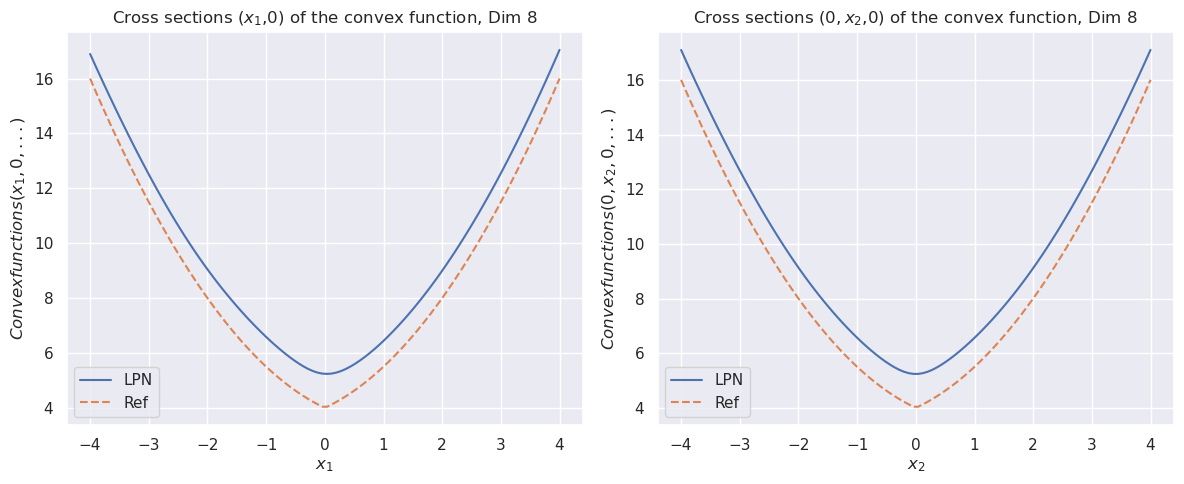

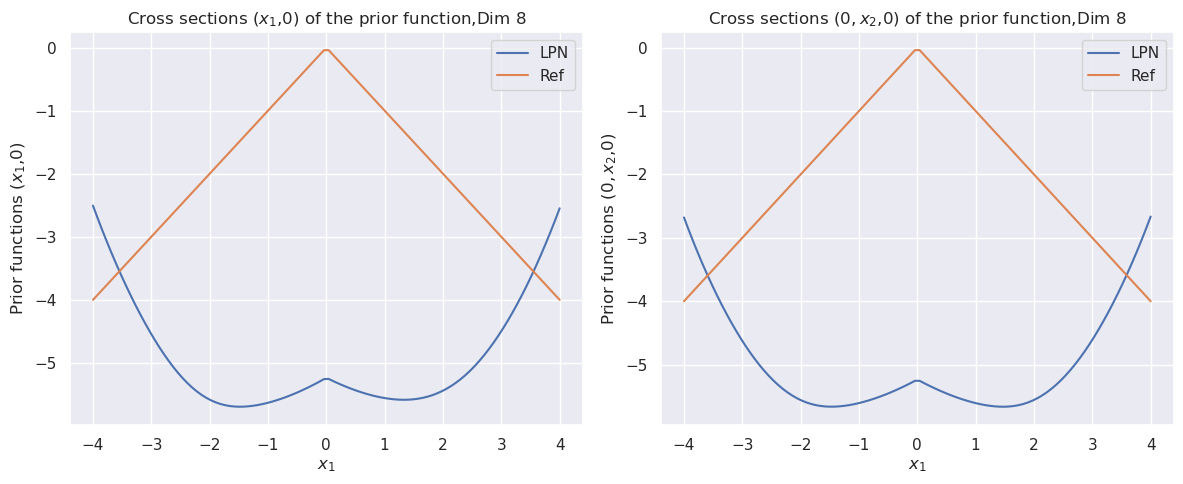

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 347.0162048339844
iteration 0 loss 1309.560546875


iteration 5000 loss 0.3132834732532501


iteration 10000 loss 0.21933454275131226


iteration 15000 loss 0.16854384541511536


iteration 20000 loss 0.07991116493940353


iteration 25000 loss 0.0537605956196785


iteration 30000 loss 0.03590664640069008


iteration 35000 loss 0.042416177690029144


iteration 40000 loss 0.013427182100713253


iteration 45000 loss 0.010432780720293522


iteration 50000 loss 0.008777187205851078


iteration 55000 loss 0.014529858715832233


iteration 60000 loss 0.0066062333062291145


iteration 65000 loss 0.005787225440144539


iteration 70000 loss 0.0052367220632731915


iteration 75000 loss 0.004674841184169054


iteration 80000 loss 0.0041662706062197685


iteration 85000 loss 0.0036617442965507507


iteration 90000 loss 0.003297062125056982


iteration 95000 loss 0.0029869764111936092


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.0027054911479353905


iteration 105000 loss 0.00291048432700336


iteration 110000 loss 0.0022627832368016243


iteration 115000 loss 0.0020606403704732656


iteration 120000 loss 0.0018923564348369837


iteration 125000 loss 0.0017514069331809878


iteration 130000 loss 0.0016301233554258943


iteration 135000 loss 0.0015220213681459427


iteration 140000 loss 0.0017342246137559414


iteration 145000 loss 0.0013277786783874035


iteration 150000 loss 0.001318124937824905


iteration 155000 loss 0.0011791669530794024


iteration 160000 loss 0.0011159973219037056


iteration 165000 loss 0.0010589557932689786


iteration 170000 loss 0.0010080080246552825


iteration 175000 loss 0.0009638601914048195


iteration 180000 loss 0.0009240040089935064


iteration 185000 loss 0.0008885023999027908


iteration 190000 loss 0.0008561194408684969


iteration 195000 loss 0.0008272815612144768


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.0008006590651348233


iteration 205000 loss 0.0007886796956881881


iteration 210000 loss 0.0007645246223546565


iteration 215000 loss 0.0007423338247463107


iteration 220000 loss 0.0007219560211524367


iteration 225000 loss 0.0007031351560726762


iteration 230000 loss 0.0006843165610916913


iteration 235000 loss 0.0006691867019981146


iteration 240000 loss 0.0006542589981108904


iteration 245000 loss 0.0006411724025383592


iteration 250000 loss 0.000628490699455142


iteration 255000 loss 0.0006167676765471697


iteration 260000 loss 0.0006056606071069837


iteration 265000 loss 0.0005953067447990179


iteration 270000 loss 0.0005846530548296869


iteration 275000 loss 0.0005755059537477791


iteration 280000 loss 0.0005659667658619583


iteration 285000 loss 0.0005578817799687386


iteration 290000 loss 0.0005497347447089851


iteration 295000 loss 0.0005423983675427735


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.0005352588486857712


iteration 305000 loss 0.0005318063194863498


iteration 310000 loss 0.0005238704616203904


iteration 315000 loss 0.0005168768111616373


iteration 320000 loss 0.0005096386303193867


iteration 325000 loss 0.0005033998168073595


iteration 330000 loss 0.0004974697949364781


iteration 335000 loss 0.000491696351673454


iteration 340000 loss 0.0004865504743065685


iteration 345000 loss 0.00048120066639967263


iteration 350000 loss 0.00047572379116900265


iteration 355000 loss 0.0004712528025265783


iteration 360000 loss 0.00046638003550469875


iteration 365000 loss 0.0004619864921551198


iteration 370000 loss 0.0004577240615617484


iteration 375000 loss 0.00045351198059506714


iteration 380000 loss 0.00044953907490707934


iteration 385000 loss 0.0004457351751625538


iteration 390000 loss 0.000442003074567765


iteration 395000 loss 0.00043844932224601507


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.0004350632952991873


iteration 405000 loss 0.000433889013947919


iteration 410000 loss 0.0004318661813158542


iteration 415000 loss 0.000429931707913056


iteration 420000 loss 0.0004280632419977337


iteration 425000 loss 0.00042624911293387413


iteration 430000 loss 0.00042448233580216765


iteration 435000 loss 0.0004227620374877006


iteration 440000 loss 0.00042107823537662625


iteration 445000 loss 0.00041943276301026344


iteration 450000 loss 0.0004178225062787533


iteration 455000 loss 0.00041624935693107545


iteration 460000 loss 0.00041470970609225333


iteration 465000 loss 0.0004131989262532443


iteration 470000 loss 0.00041171759949065745


iteration 475000 loss 0.000410262233344838


iteration 480000 loss 0.00040883064502850175


iteration 485000 loss 0.00040742449345998466


iteration 490000 loss 0.0004060431965626776


iteration 495000 loss 0.00040468471706844866


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


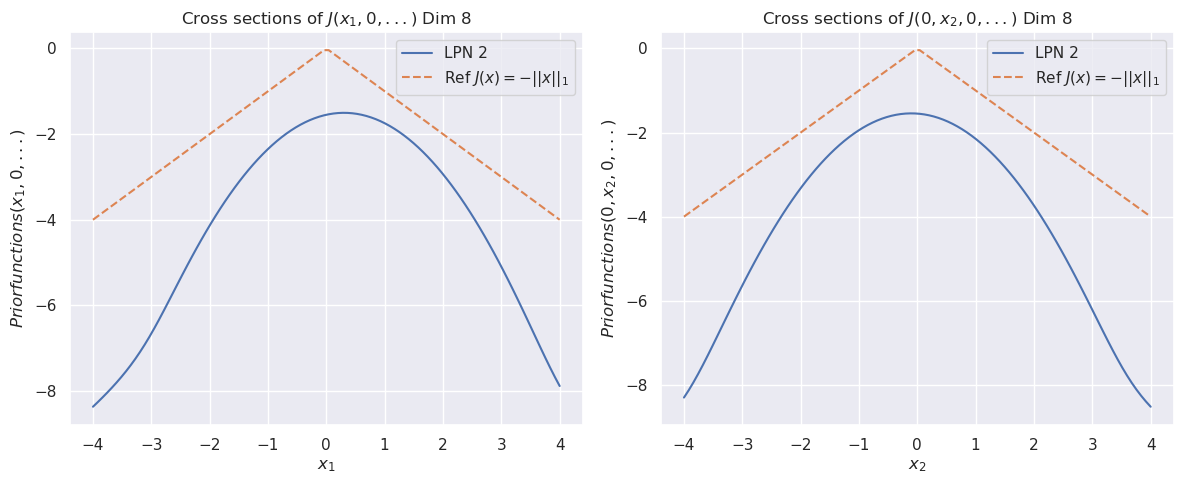

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)